This notebook is my take on Ben Koger's fruit bat tracking code. I'll need to adapt the parameters and certain parts of the code to get things running. 

### Exported TMC frames 
The TMC frames when exported to PNG results in a 3 channel image with the same pixel values on all channels. 

### Type of image 
The objects need to be *dark* over a bright background. 

In [1]:
import cv2 
import numpy as np
import glob
import os
import shutil
import tqdm

import matplotlib.pyplot as plt



In [2]:
%matplotlib notebook

In [3]:
import bat_functions as kbf

In [4]:
def invert_images(image_paths):
    '''
    TB code 
    
    Parameters
    ----------
    image_paths : list
        List with file paths
    
    Returns
    -------
    inverted_images : np.array
    
    '''
    inverted_images = []
    
    for each in image_paths:
        image = cv2.imread(each)
        image_inverted = ~image
        inverted_images.append(image_inverted)
    return inverted_images
        
def invert_and_save_images(image_paths):
    '''
    TB code 
    
    Makes inverted images in a folder at the same level as image_paths
    '''
    inverted_images = invert_images(image_paths)
    path_components = list(os.path.split(image_paths[0]))
    samelevel_dir = '/'.join(path_components[:-1])
    
    
    for each,filepath in zip(inverted_images,image_paths):
        filename = os.path.split(filepath)[-1]
        cv2.imwrite(samelevel_dir + '/invert_'+filename, each)
    
    

In [5]:
def simple_process_frame(image_files,  bat_thresh, bat_area, focal_frame_ind):
    '''
    Assumes dark bats over a bright background. 
    
    Alterations from original:
    * remove background_array_size, first_frame arguments
    
    original code by BK, comments and alterations by TB
    
    Parameters
    ----------
    image_files : list 
        List with file paths 
    first_frame : int
    bat_thresh : float
        Threshold above which a bat is detected
    bat_area : float
        Minimum area that a bat occupies in pixels
    focal_frame_ind : int
        Index of image to be processed. 
    
    Deprecated Arguments
    ---------------------
    background_array_size : int
    first_frame : int
        
    '''

    images = []
    for file in image_files:
        image = cv2.imread(file)
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    images = np.stack(images)
    # Here taking blue channel. Should |be changed is images already 2D
    background_sum = np.sum(images[:,:,:,2],0, dtype=np.int16)

    bat_centers, bat_areas, bat_contours, rect_angles, bat_sizes, bat_rects, bat_thresh, binary = kbf.process_frame(
                                    images, focal_frame_ind, bat_thresh, background_sum, bat_area, debug=True)
    
    return {'bat_centers': bat_centers,
            'bat_areas': bat_areas,
            'bat_contours': bat_contours,
            'rect_angles': rect_angles,
            'bat_sizes': bat_sizes,
            'bat_rects': bat_rects,
            'bat_thresh': bat_thresh,
            'binary': binary}

In [6]:
image_folder = "./thermal_frames/" 

In [14]:

bat_thresh = .1
bat_area = 0.5

if not os.path.isdir('tracked_frames/'):
    os.mkdir('tracked_frames/')

for camera_id in ['K1','K2','K3']:
    image_files = sorted(glob.glob(image_folder + f'/*{camera_id}*.png'))

    for focal_frame_ind,_ in tqdm.tqdm(enumerate(image_files)):
        output = simple_process_frame(image_files, 
                                      bat_thresh, bat_area,
                                      focal_frame_ind)



        frame = cv2.imread(image_files[focal_frame_ind])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        circled_image = kbf.draw_circles_on_image(frame, 
                                              output['bat_centers'], 
                                              output['bat_sizes'], 
                                              rects=output['bat_rects'])

        circled_binary_image = kbf.draw_circles_on_image(output['binary'].astype(np.uint8), 
                                                     output['bat_centers'], 
                                                     output['bat_sizes'], 
                                                     rects=output['bat_rects'])

        plt.imsave('tracked_frames/'+f'{camera_id}_{focal_frame_ind}_tracked.png', circled_image)

75it [01:36,  1.29s/it]
75it [01:11,  1.05it/s]
75it [01:10,  1.06it/s]


<IPython.core.display.Javascript object>


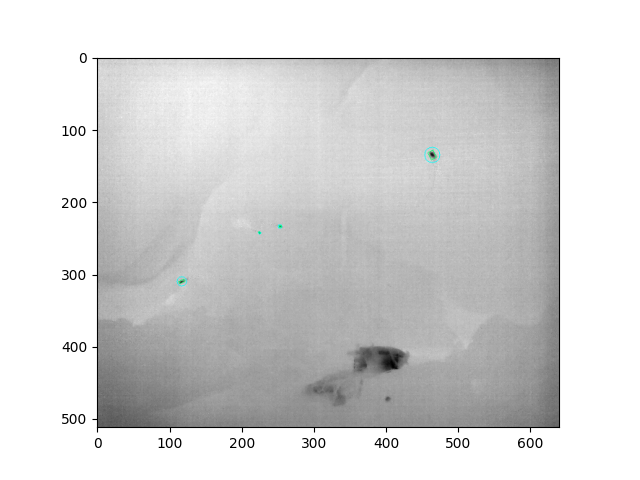

In [13]:
plt.figure()
plt.imshow(circled_image)